<a href="https://colab.research.google.com/github/richeym-umich/UsingTextAsDataWorkshop/blob/main/Text_as_Data_Workshop_Complete_Python_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Analyzing UN Dataset for Topic Modeling
This notebook contains the completed python code for the Text as Data Workshop. Please see the github repository for the skeleton code to complete yourself. 

To analyze the topics present in a group of UN documents, we first have to install the necessary python packages. These packages will allow us to read in the xml data, flatten the xml structure, and organize the data into a dataframe. 

In [7]:
#Install all our necessary packages
!pip3 install pandas-read-xml
import pandas_read_xml as pdx
from pandas_read_xml import flatten, fully_flatten, auto_separate_tables
import os
from zipfile import ZipFile
import pandas as pd
!pip3 install contractions

Next, we have to identify the source of the data. To load the data into your workspace, use the upload file in the panel on the left. Then, run this piece of code to unzip the zip file into the workspace. 

In [8]:
#Load in the data we'll be working with and unzip it
file_name = 'pc_iii.zip'
with ZipFile(file_name, 'r') as zipping:
  zipping.extractall()
  print('unzip done')

unzip done


The body of the text that we're analyzing is located a few layers down within the xml structure. To access it, we need to traverse the xml structure and extract the body text. We then store this text in a dataframe with the name of the file as an identifier. 

In [9]:
#Walk through our xml directory structure and find the body of text
directory = 'pc_iii'
paragraphs = []
for filename in os.listdir(directory):
  xmlFilename = os.path.join(directory, filename)
  print(xmlFilename)
  if os.path.isdir(xmlFilename):
    continue
  #Read in text and flatten columns to get text data
  df = pdx.read_xml(xmlFilename, ['TEI.2', 'text', 'body'], encoding='utf8')
  df = fully_flatten(df, ['p|@id'])
  df = df.drop(['p|@id', 'p|s|@id', 'p|s|@lang'], axis=1)
  df = df.rename(columns={'p|s':'text'})
  paragraph = ''
  for i in range(0, len(df)):
    sentence = df.loc[i].values[0]
    paragraph += sentence
    paragraph += ' '
  paragraphs.append([filename, paragraph])
paragraphDF = pd.DataFrame.from_dict(paragraphs)
#rename columns
paragraphDF.columns=['filename', 'text']
paragraphDF.head()

pc_iii/5.xml
pc_iii/wp_5.xml
pc_iii/wp_31.xml
pc_iii/wp_32.xml
pc_iii/wp_10.xml
pc_iii/wp_42.xml
pc_iii/wp_1.xml
pc_iii/sr_17.xml
pc_iii/wp_26.xml
pc_iii/wp_41.xml
pc_iii/wp_22.xml
pc_iii/sr_2.xml
pc_iii/wp_13.xml
pc_iii/19.xml
pc_iii/wp_8.xml
pc_iii/wp_19.xml
pc_iii/wp_3.xml
pc_iii/wp_11.xml
pc_iii/wp_35.xml
pc_iii/wp_33.xml
pc_iii/wp_43.xml
pc_iii/wp_17.xml
pc_iii/wp_40.xml
pc_iii/sr_6.xml
pc_iii/wp_44.xml
pc_iii/wp_25.xml
pc_iii/11.xml
pc_iii/16.xml
pc_iii/wp_28.xml
pc_iii/wp_45.xml
pc_iii/wp_18.xml
pc_iii/wp_6.xml
pc_iii/wp_7.xml
pc_iii/12.xml
pc_iii/wp_39.xml
pc_iii/wp_38.xml
pc_iii/wp_46.xml
pc_iii/wp_37.xml
pc_iii/wp_14.xml
pc_iii/wp_15.xml
pc_iii/wp_20.xml
pc_iii/14.xml
pc_iii/wp_21.xml
pc_iii/1.xml
pc_iii/wp_16.xml
pc_iii/13.xml
pc_iii/4.xml
pc_iii/3.xml
pc_iii/7.xml
pc_iii/17.xml
pc_iii/10.xml
pc_iii/wp_34.xml
pc_iii/21.xml
pc_iii/8.xml
pc_iii/wp_2.xml
pc_iii/9.xml
pc_iii/wp_23.xml
pc_iii/wp_36.xml
pc_iii/wp_24.xml
pc_iii/20.xml
pc_iii/wp_27.xml
pc_iii/wp_9.xml
pc_iii/18.xml


,filename,text
0,5.xml,Australia's commitment to the Treaty and the o...
1,wp_5.xml,"5. In this connection, the Group of Non-Aligne..."
2,wp_31.xml,1. Nuclear disarmament forms one of the fundam...
3,wp_32.xml,"1. The first atomic bombs, dropped on Hiroshim..."
4,wp_10.xml,2. As a part of its efforts to promote the imp...


Now we can start our data processing. First, we import some packages from nltk. We also define some utility functions. 

In [10]:
#Import libraries necessary for processing text
import string
import contractions
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

#Utility functions to get part of speech and key words
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def get_key_words(comment):
    words = TweetTokenizer().tokenize(comment)
    words = [w for w in words if len(w) > 3] #word length
    words = [w for w in words if w.lower() not in stopwords]
    words = [WordNetLemmatizer().lemmatize(w, get_wordnet_pos(w)) for w in words]
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


The next few lines of code manipulate and clean the text. We convert all text to lowercase and expand contractions. We also remove punctuation and stopwords. 

In [11]:
#Manipulate text to get clean output
paragraphDF['text'] = paragraphDF['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#Expand contractions
paragraphDF['text'] = paragraphDF['text'].apply(lambda x: " ".join(contractions.fix(word) for word in x.split()))

#Remove all punctuation
paragraphDF['text'] = paragraphDF['text'].str.translate(str.maketrans('', '', string.punctuation))

#Remove stopwords
stopwords  = [w.lower() for w in list(stopwords.words('english'))]
paragraphDF['keywords'] = paragraphDF['text'].apply(get_key_words)

#Stemming
#st = PorterStemmer()
#paragraphDF['keywords'] = paragraphDF['keywords'].apply(lambda x: [st.stem(word) for word in x])
paragraphDF.head()

,filename,text,keywords
0,5.xml,australias commitment to the treaty and the ob...,"[australia, commitment, treaty, objective, ach..."
1,wp_5.xml,5 in this connection the group of nonaligned s...,"[connection, group, nonaligned, state, party, ..."
2,wp_31.xml,1 nuclear disarmament forms one of the fundame...,"[nuclear, disarmament, form, fundamental, pill..."
3,wp_32.xml,1 the first atomic bombs dropped on hiroshima ...,"[first, atomic, bomb, drop, hiroshima, nagasak..."
4,wp_10.xml,2 as a part of its efforts to promote the impl...,"[part, effort, promote, implementation, 2010, ..."


Finally, we identify the unigrams, bigrams, and trigrams in the text. For each text, we identify the n-grams, and then count the number of times it occurs in that text. After analyzing all the data, we graph the results. 

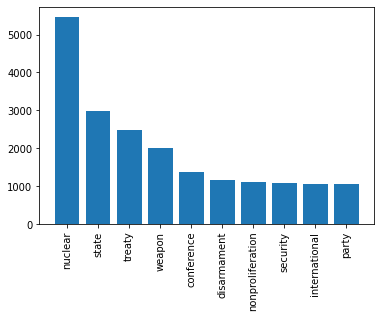

1-grams(word,count,perentage):
[('nuclear', 5464, '4.39E-2'), ('state', 2976, '2.39E-2'), ('treaty', 2489, '2.00E-2'), ('weapon', 2019, '1.62E-2'), ('conference', 1378, '1.11E-2'), ('disarmament', 1152, '9.26E-3'), ('nonproliferation', 1098, '8.82E-3'), ('security', 1086, '8.73E-3'), ('international', 1057, '8.49E-3'), ('party', 1050, '8.44E-3')]



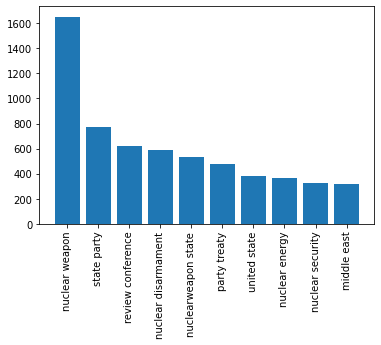

2-grams(word,count,perentage):
[('nuclear weapon', 1652, '1.33E-2'), ('state party', 774, '6.22E-3'), ('review conference', 618, '4.97E-3'), ('nuclear disarmament', 587, '4.72E-3'), ('nuclearweapon state', 535, '4.30E-3'), ('party treaty', 480, '3.86E-3'), ('united state', 379, '3.05E-3'), ('nuclear energy', 366, '2.94E-3'), ('nuclear security', 327, '2.63E-3'), ('middle east', 318, '2.56E-3')]



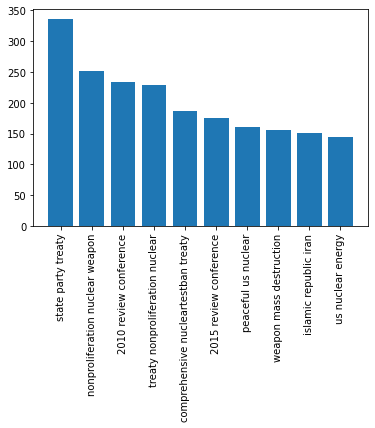

3-grams(word,count,perentage):
[('state party treaty', 336, '2.70E-3'), ('nonproliferation nuclear weapon', 252, '2.03E-3'), ('2010 review conference', 234, '1.88E-3'), ('treaty nonproliferation nuclear', 229, '1.84E-3'), ('comprehensive nucleartestban treaty', 186, '1.50E-3'), ('2015 review conference', 175, '1.41E-3'), ('peaceful us nuclear', 160, '1.29E-3'), ('weapon mass destruction', 156, '1.26E-3'), ('islamic republic iran', 151, '1.21E-3'), ('us nuclear energy', 145, '1.17E-3')]



In [12]:
#Libraries needed for analysis
import collections
from collections import Counter
from decimal import Decimal
import matplotlib.pyplot as plt

#We will be gathering unigrams, bigrams, and trigrams
N = 3 #N-grams
#Looking at the top 10 results for each n-gram
T = 10 #Max top words

#Utility function to form n-grams
def n_grams(kw, n):
    output = []
    for i in range(len(kw)-n+1):
        output.append(kw[i:i+n])
    return output

#Loop through each length of n-gram, form keywords, and count the occurrences of each
for n in range(1, N+1):
    key_words = paragraphDF["keywords"].tolist()
    key_words = [[' '.join(x) for x in n_grams(kw, n)] for kw in key_words]
    row_key_words = key_words
    key_words = [[each_word] for each_list in key_words for each_word in each_list]
    count = dict(Counter(map(tuple, key_words)))
    count = sorted(count.items(), key=lambda x: x[1], reverse=True)
    count = [(c[0][0],c[1]) for c in count]
    data = count[:T]
    x, y = zip(*data)

    #Format data into plotting
    most_important_words = list(x)
    allMatches = []
    for row in row_key_words:
      matches = []
      for word in most_important_words:
        if word in row:
          matches.append(word)
      allMatches.append(matches)
    columnName = str(n) + '-grams'
    paragraphDF[columnName] = allMatches

    plt.bar(x,y)
    plt.xticks(rotation = 90)
    plt.show()
    sumc = sum([c[1] for c in count])
    def get_sci_val(x):
        x = round(x/sumc, 6)
        x = "{:.2E}".format(Decimal(x))
        return x
    count = [(c[0],c[1],get_sci_val(c[1])) for c in count]
    print("{}-grams(word,count,perentage):\n{}\n".format(n,count[:T]))

In [13]:
paragraphDF

,filename,text,keywords,1-grams,2-grams,3-grams
0,5.xml,australias commitment to the treaty and the ob...,"[australia, commitment, treaty, objective, ach...","[nuclear, state, treaty, weapon, conference, d...","[nuclear weapon, state party, review conferenc...","[state party treaty, nonproliferation nuclear ..."
1,wp_5.xml,5 in this connection the group of nonaligned s...,"[connection, group, nonaligned, state, party, ...","[nuclear, state, treaty, weapon, conference, d...","[nuclear weapon, state party, review conferenc...","[state party treaty, nonproliferation nuclear ..."
2,wp_31.xml,1 nuclear disarmament forms one of the fundame...,"[nuclear, disarmament, form, fundamental, pill...","[nuclear, state, treaty, weapon, conference, d...","[nuclear weapon, state party, review conferenc...","[state party treaty, nonproliferation nuclear ..."
3,wp_32.xml,1 the first atomic bombs dropped on hiroshima ...,"[first, atomic, bomb, drop, hiroshima, nagasak...","[nuclear, state, treaty, weapon, conference, d...","[nuclear weapon, state party, review conferenc...","[state party treaty, nonproliferation nuclear ..."
4,wp_10.xml,2 as a part of its efforts to promote the impl...,"[part, effort, promote, implementation, 2010, ...","[nuclear, state, treaty, weapon, conference, d...","[nuclear weapon, state party, review conferenc...","[nonproliferation nuclear weapon, 2010 review ..."
...,...,...,...,...,...,...
66,2.xml,1 germany considers the treaty on the nonproli...,"[germany, considers, treaty, nonproliferation,...","[nuclear, state, treaty, weapon, conference, d...","[nuclear weapon, review conference, nuclear di...","[nonproliferation nuclear weapon, 2010 review ..."
67,sr_5.xml,1 mr tiendrebeogo burkina faso said that while...,"[tiendrebeogo, burkina, faso, say, treaty, non...","[nuclear, state, treaty, weapon, conference, d...","[nuclear weapon, state party, review conferenc...","[state party treaty, nonproliferation nuclear ..."
68,6.xml,1 the treaty on the nonproliferation of nuclea...,"[treaty, nonproliferation, nuclear, weapon, co...","[nuclear, state, treaty, weapon, conference, d...","[nuclear weapon, state party, review conferenc...","[state party treaty, nonproliferation nuclear ..."
69,sr_3.xml,1 ms gottemoeller united states of america sai...,"[gottemoeller, united, state, america, say, tr...","[nuclear, state, treaty, weapon, conference, d...","[nuclear weapon, state party, review conferenc...","[state party treaty, nonproliferation nuclear ..."


### LDA (Latent Dirichlet Allocation) Topic Modeling
An LDA Topic Model combines dimensionality reduction and unsupervised learning to discover structures of text. In this case, we are looking for topics relevant to the text. We will build clusters of texts that have a topic made up of a combination of keywords. 

First, we will load some libraries and write auxiliary functions to put the data in the right format. 

In [14]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

#Auxiliary functions to remove stopwords and convert sentences into words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

#We take the text and convert it to words
data = paragraphDF.text.values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['australias', 'commitment', 'treaty', 'objective', 'achieving', 'world', 'without', 'nuclear', 'weapons', 'remains', 'undiminished', 'hold', 'highest', 'standards', 'compliance', 'obligations', 'australia', 'continues', 'prominent', 'active', 'advocate', 'nuclear', 'disarmament', 'initiatives', 'promoted', 'include', 'comprehensive', 'ban', 'nuclear', 'tests']


Next, we create a dictionary and corpus to represent our words

In [15]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 5), (11, 1), (12, 1), (13, 1), (14, 9), (15, 3), (16, 1), (17, 1), (18, 1), (19, 6), (20, 4), (21, 1), (22, 6), (23, 2), (24, 1), (25, 11), (26, 1), (27, 94), (28, 7), (29, 5)]


We will train an LDA model by building a model with a specified number of topics where each topic is a combination of keywords, and each keyword contributes a certain amount to the overall topic. In this example, we will use 3 topics. 

In [23]:
from pprint import pprint
num_topics = 3

lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0,
  '0.036*"nuclear" + 0.016*"weapons" + 0.015*"treaty" + 0.015*"states" + '
  '0.010*"security" + 0.009*"disarmament" + 0.009*"international" + '
  '0.008*"conference" + 0.007*"iaea" + 0.006*"parties"'),
 (1,
  '0.044*"nuclear" + 0.019*"treaty" + 0.014*"states" + 0.012*"weapons" + '
  '0.009*"security" + 0.009*"iaea" + 0.008*"review" + 0.008*"international" + '
  '0.007*"parties" + 0.007*"conference"'),
 (2,
  '0.044*"nuclear" + 0.028*"states" + 0.019*"treaty" + 0.017*"weapons" + '
  '0.012*"conference" + 0.010*"disarmament" + 0.008*"international" + '
  '0.008*"iaea" + 0.008*"security" + 0.007*"parties"')]


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Finally, we will visualize our results. Note that in this unsupervised machine learning problem, we didn't need to know what the topics would be. We only needed to specify the number of topics we wanted, and we can analyze what pieces of information each text has in common with others in its same topic. 

In [24]:
!pip3 install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.006237  0.001687       1        1  59.057321
1      0.001445 -0.005560       2        1  26.704388
0      0.004792  0.003873       3        1  14.238291, topic_info=               Term         Freq        Total Category  logprob  loglift
741         nuclear  5250.000000  5250.000000  Default  30.0000  30.0000
1240        weapons  1865.000000  1865.000000  Default  29.0000  29.0000
1181         treaty  2275.000000  2275.000000  Default  28.0000  28.0000
1040       security  1001.000000  1001.000000  Default  27.0000  27.0000
595   international   999.000000   999.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
749     obligations    48.181231   315.439491   Topic3  -5.8930   0.0702
1029     safeguards    61.078115   564.091030   Topic3  -5.6558  -0.2738
690          middle    47.199875   309.432478   Topic3  -5.9136   0.0689
522           group    55.301396   464.205199   Topic3  -5.7552  -0.1783
1260          would    48.082844   431.594487   Topic3  -5.8950  -0.2453

[278 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
17        1  0.513440   accounting
17        2  0.239605   accounting
17        3  0.239605   accounting
1367      1  0.761792  acquisition
1367      2  0.145103  acquisition
...     ...       ...          ...
1260      2  0.208529        would
1260      3  0.111216        would
1268      1  0.588385         zone
1268      2  0.203819         zone
1268      3  0.203819         zone

[538 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])